In [5]:
import scipy.io
import pandas as pd
import numpy as np
import re

import matplotlib.pyplot as plt

In [6]:
def find_onoff(pulsez_df, currun, tr=1.8, volumes=245):
    # load important info
    ab_t0 = pulsez_df['timing'][pulsez_df['run']==currun].iloc[0]  # this is for run 1
    ab_end = pulsez_df['timing'][pulsez_df['run']==currun].iloc[-1]  # this is for run 1
    
    # set range
    pulserangerun = np.linspace(ab_t0, ab_end, num=volumes, retstep=False)
    ontimes = pulsez_df['timing'][pulsez_df['run']==currun].to_numpy()
    
    # get off times
    offtimes = np.abs(pulserangerun[:,None]-ontimes).argmin(0) # get on times
    onoff = np.ones(volumes)
    onoff[offtimes] = 0 # set off times to 0
    
    return(pulserangerun, onoff)



def find_block(pulsez_df, currun, tr=1.8, volumes=245):
    # load important info
    ab_t0 = pulsez_df['timing'][pulsez_df['run']==currun].iloc[0]  # this is for run 1
    ab_end = pulsez_df['timing'][pulsez_df['run']==currun].iloc[-1]  # this is for run 1
    blocks = pulsez_df['block'][pulsez_df['run']==currun].to_numpy()
    
    # set range
    pulserangerun = np.linspace(ab_t0, ab_end, num=volumes, retstep=False)
    ontimes = pulsez_df['timing'][pulsez_df['run']==currun].to_numpy()

    # get off times
    offtimes = np.abs(pulserangerun[:,None]-ontimes).argmin(0) # get on times
    allblocks = np.empty(volumes)
    allblocks[:] = np.nan
    
    allblocks[offtimes] = blocks # set off times to 0
    allblocks = ffill(allblocks) # forward fill the array
    
    return(allblocks)

def closest_vol(volumes_df, timingz):
    a = volumes_df['timing'].to_numpy()
    b = timingz

    # get volume
    seq_vol = np.abs(a[:,None]-b).argmin(0)
    rel_vol = seq_vol - (runz-1)*float(len(volumes_df[volumes_df['run'] == 1]))
    return(seq_vol, rel_vol.astype(int))

def closest_vol_floor(volumes_df, timingz):
    a = volumes_df['timing'].to_numpy()
    b = timingz

    # get volume
    dist = (a[:,None]-b) # get the distance
    dist[dist < 0.05] = 999 # get rid of pos distancane (- some window)
    seq_vol = np.abs(dist).argmin(0)
    rel_vol = seq_vol - (runz-1)*float(len(volumes_df[volumes_df['run'] == 1]))
    return(seq_vol, rel_vol.astype(int))

def closest_vol_timing(volumes_df, timingz):
    a = volumes_df['timing'].to_numpy()
    b = timingz

    # get volume
    seq_vol = np.abs(a[:,None]-b).argmin(0)
    rel_vol = seq_vol - (runz-1)*float(len(volumes_df[volumes_df['run'] == 1]))
    return(seq_vol, rel_vol)

def ffill(arr, axis=0):
    idx_shape = tuple([slice(None)] + [np.newaxis] * (len(arr.shape) - axis - 1))
    idx = np.where(~np.isnan(arr), np.arange(arr.shape[axis])[idx_shape], 0)
    np.maximum.accumulate(idx, axis=axis, out=idx)
    slc = [np.arange(k)[tuple([slice(None) if dim==i else np.newaxis
        for dim in range(len(arr.shape))])]
        for i, k in enumerate(arr.shape)]
    slc[axis] = idx
    return arr[tuple(slc)]

def flatten(d):
    return(pd.json_normalize(d, sep='_').to_dict(orient='records')[0])

## load the actual information

In [7]:
pp = 2
mat = scipy.io.loadmat('/media/jorvhar/Data1/MRIData/timing data/data/{}/{}-mainpred.mat'.format(pp, pp))
stimuli = scipy.io.loadmat('/media/jorvhar/Data1/MRIData/timing data/stimuli/{}/{}_main_stims.mat'.format(pp, pp))

## Quickly check the data

In [8]:
blocknr = 1
idxblock = np.where(mat['timingz'][1] == blocknr) # where block is 1

#get frequency presentation data for block
frequencies = stimuli['pres_freq'][blocknr-1, :]

# other values
tps = np.sum(mat['timingz'][3, idxblock] == 1) # get trials per secion

#get timings back from mat file, substract begin time
timings = mat['timingz'][4, idxblock] - np.min(mat['timingz'][4, idxblock]) 

matidx = np.where(mat['segmentz'][1] == blocknr)

centa = 2**np.repeat(mat['segmentz'][7][matidx], tps)   # cent freq a
centb = 2**np.repeat(mat['segmentz'][8][matidx], tps)  # cent freq b
proba = np.repeat(mat['segmentz'][5][matidx], tps)  # prob a
probb = np.repeat(mat['segmentz'][6][matidx], tps)  # prob b


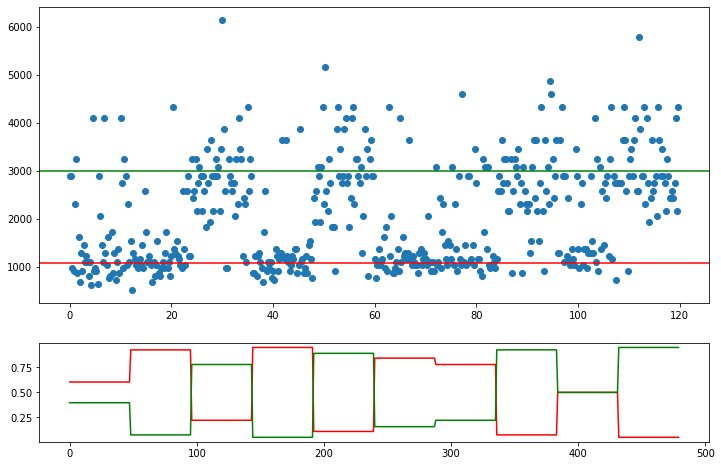

In [9]:
# senatry check the data
fig, ax = plt.subplots(2, 1, gridspec_kw={'height_ratios': [3, 1]}, figsize=(12, 8))

ax[0].scatter(timings, frequencies)
ax[0].axhline(y=centa[0], color='r', linestyle='-')
ax[0].axhline(y=centb[0], color='g', linestyle='-')

ax[1].plot(proba, color='r')
ax[1].plot(probb, color='g')

##  Put information of pulsez into a pandas dataframe

In [10]:
nr_runs = 12

# set empty array to concatenate pulse fetched data
allpulsez = 0

# loop over runs and parse data
for currun in np.arange(1,nr_runs+1):
    pulsez = scipy.io.loadmat('/media/jorvhar/Data1/MRIData/timing data/data/{}/_{}-r{}-pulses.mat'.format(pp, pp, currun))['pulsez']
    pulsez = np.vstack([np.repeat(currun, pulsez.shape[1]), pulsez])
    try:
        allpulsez = np.concatenate((allpulsez,pulsez),axis=1)
    except:
        allpulsez = pulsez
        
# put in dataframe
pulsez_df = pd.DataFrame(np.transpose(allpulsez), columns=['run', 'block', 'timing'])
pulsez_df

,run,block,timing
0,1.0,1.0,607354.205883
1,1.0,1.0,607356.006130
2,1.0,1.0,607357.805883
3,1.0,1.0,607359.606107
4,1.0,1.0,607361.406175
...,...,...,...
523,12.0,36.0,613531.307240
524,12.0,36.0,613533.107246
525,12.0,36.0,613534.907253
526,12.0,36.0,613536.707040


### Use the raw pulse information to get volume level information

In [11]:
# settings
tr = 1.8
volumes = 245

# precreate dicts
tm = {}
onoff = {}
block = {}

# loop over all the runs
for currun in np.arange(1, nr_runs+1):
    tm[currun], onoff[currun] = find_onoff(pulsez_df, currun, tr=tr, volumes=volumes)
    block[currun] = find_block(pulsez_df, 1, tr=1.8, volumes=245)

In [12]:
# append to one full array
tmz = np.array([])
onoffz = np.array([])
runz = np.array([])
blockz = np.array([])

# loop over runs and fill
for currun in tm.keys():
    tmz = np.append(tmz, tm[currun])
    onoffz = np.append(onoffz, onoff[currun]) 
    runz = np.append(runz, np.array([currun] * len(tm[currun])))
    blockz = np.append(blockz, block[currun]) 
    
# put everything in a pandas dataframe
df_inf = {'timing':tmz, 'run':runz, 'block':blockz, 'on-times':onoffz}
volumes_df = pd.DataFrame(df_inf)

#### Add other information de dataframe if desired

In [13]:
volumes_df = volumes_df.assign(adapt = 0)
volumes_df = volumes_df.assign(pred = 0)
volumes_df.head(12)

,timing,run,block,on-times,adapt,pred
0,607354.205883,1.0,1.0,0.0,0,0
1,607356.005910,1.0,1.0,0.0,0,0
2,607357.805936,1.0,1.0,0.0,0,0
3,607359.605962,1.0,1.0,0.0,0,0
4,607361.405988,1.0,1.0,0.0,0,0
5,607363.206014,1.0,1.0,1.0,0,0
6,607365.006040,1.0,1.0,1.0,0,0
7,607366.806066,1.0,1.0,1.0,0,0
8,607368.606092,1.0,1.0,1.0,0,0
9,607370.406118,1.0,1.0,1.0,0,0


## get trial level dataframe

In [14]:
# set arrays
freqz   = np.array([])
timingz  = np.array([])
runz     = np.array([])
blockz   = np.array([])
segmenz  = np.array([])
centaz   = np.array([])
centbz   = np.array([])
probaz   = np.array([])
probbz   = np.array([])

for blk in np.arange(1, pulsez_df['block'].max()+1):
    # get blockidx
    idxblock = np.where(mat['timingz'][1] == blk) # where block is 1

    #get frequency presentation data for block
    frequencies = stimuli['pres_freq'][int(blk)-1, :]
    
    # other values
    tps = np.sum(mat['timingz'][3, idxblock] == 1) # get trials per secion
    
    #get timings back from mat file, substract begin time
    timings = mat['timingz'][4, idxblock]
    matidx = np.where(mat['segmentz'][1] == blk)
    
    # append to arrays
    freqz = np.append(freqz, frequencies)
    timingz = np.append(timingz, timings)
    runz = np.append(runz, np.repeat(mat['segmentz'][0][matidx], tps))
    blockz = np.append(blockz, np.repeat(mat['segmentz'][1][matidx], tps))
    segmenz = np.append(segmenz, np.repeat(mat['segmentz'][2][matidx], tps))
    centaz = np.append(centaz, 2**np.repeat(mat['segmentz'][7][matidx], tps))   # cent freq a
    centbz = np.append(centbz, 2**np.repeat(mat['segmentz'][8][matidx], tps))  # cent freq b
    probaz = np.append(probaz, np.repeat(mat['segmentz'][5][matidx], tps))
    probbz = np.append(probbz, np.repeat(mat['segmentz'][6][matidx], tps))
    
# oct variant 
freqz_oct = np.log2(freqz)
centaz_oct = np.log2(centaz)
centbz_oct = np.log2(centbz)

# get closest pulse
vol_absz, vol_relz = closest_vol(volumes_df, timingz)
vol_abs_flrz, vol_rel_flrz = closest_vol_floor(volumes_df, timingz)

In [15]:
# put data into a dictionary and subsequentially in a dataframe
stim_df_dict = {'frequencies': freqz,
                'frequencies_oct': freqz_oct,
                'timing': timingz,
                'closest_volume_rel' : vol_relz,
                'closest_volume_abs' : vol_absz,
                'volume_rel' : vol_rel_flrz,
                'volume_abs' : vol_abs_flrz,
                'run': runz,
                'block': blockz,
                'segment': segmenz,
                'center_freq_a': centaz,
                'center_freq_b': centbz,
                'center_freq_a_oct': centaz_oct,
                'center_freq_b_oct': centbz_oct,
                'probability_a': probaz,
                'probability_b': probbz
               }

stim_df = pd.DataFrame(stim_df_dict)

In [16]:
stim_df

,frequencies,frequencies_oct,timing,closest_volume_rel,closest_volume_abs,volume_rel,volume_abs,run,block,segment,center_freq_a,center_freq_b,center_freq_a_oct,center_freq_b_oct,probability_a,probability_b
0,2896.309376,11.500000,607363.205175,5,5,6,6,1.0,1.0,1.0,1077.614428,3000.00000,10.073625,11.550747,0.603635,0.396365
1,2896.309376,11.500000,607363.455175,5,5,6,6,1.0,1.0,1.0,1077.614428,3000.00000,10.073625,11.550747,0.603635,0.396365
2,966.527296,9.916667,607363.705175,5,5,6,6,1.0,1.0,1.0,1077.614428,3000.00000,10.073625,11.550747,0.603635,0.396365
3,912.280287,9.833333,607363.955175,5,5,6,6,1.0,1.0,1.0,1077.614428,3000.00000,10.073625,11.550747,0.603635,0.396365
4,2298.802275,11.166667,607364.205175,6,6,6,6,1.0,1.0,1.0,1077.614428,3000.00000,10.073625,11.550747,0.603635,0.396365
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17275,767.133223,9.583333,613497.053499,221,2916,221,2916,12.0,36.0,10.0,834.255221,2322.50571,9.704345,11.181466,0.891211,0.108789
17276,2169.780417,11.083333,613497.303499,221,2916,222,2917,12.0,36.0,10.0,834.255221,2322.50571,9.704345,11.181466,0.891211,0.108789
17277,1024.000000,10.000000,613497.553499,221,2916,222,2917,12.0,36.0,10.0,834.255221,2322.50571,9.704345,11.181466,0.891211,0.108789
17278,645.079578,9.333333,613497.803499,221,2916,222,2917,12.0,36.0,10.0,834.255221,2322.50571,9.704345,11.181466,0.891211,0.108789


## measures of adaptation and prediction

In [17]:
import HGF

# import fit and sim models from the hgf
from HGF import hgf_fit
from HGF import hgf_sim

# import the presentation functions for plotting and storing
from HGF import hgf_pres

# load our configuration functions
from HGF.hgf_config import *
from HGF.hgf import *

In [18]:
import Adaptation.longtrace_adaptation as longtrace_adaptation
import Adaptation.longtrace_adaptation_timedomain as longtrace_adaptation_timedomain

/home/jorvhar/miniconda3/envs/predlis/lib/python3.8/site-packages/nilearn/glm/__init__.py:55: FutureWarning: The nilearn.glm module is experimental. It may change in any future release of Nilearn.
  warn('The nilearn.glm module is experimental. '


In [19]:
import Sequence_correlations

In [20]:
# settings
mat = scipy.io.loadmat('/media/jorvhar/Data1/MRIData/timing data/data/{}/{}_settings_tonotopy.mat'.format(pp, pp))
all_freqs = mat['cfg']['freq_array'][0][0][0,:]

tunsteps       = 10
freqstep       = 1
fwhm           = np.linspace(25,(100), tunsteps)[::-1]
subsample      = np.arange(0,len(all_freqs), freqstep)
mustep         = np.diff(all_freqs[subsample])
sigmagrid      = np.log(2) / (mustep[0]* fwhm/2) **2
octgrid        = np.log2(np.exp(1) * fwhm * mustep[0])
muarray_bins   = all_freqs
muarray        = all_freqs[subsample]

In [21]:
octgrid

array([2.48049353, 2.35496265, 2.21745912, 2.06545603, 1.89553103,
       1.70288595, 1.48049353, 1.21745912, 0.89553103, 0.48049353])

In [33]:
# for now overwrite and only take tw of 1.2
#octgrid = np.array([1.2])

In [34]:
# loop over blocks
for blk in stim_df['block'].unique():
    blk

### adaptation

In [22]:
# set range of tunings and sharpnesses
pref_range  = muarray                # match t
sharp_range = octgrid

In [23]:
# for now take values from paper [change later!]
x_decay, y_decay = longtrace_adaptation.double_exp_decay_func(0.1399, 0.85, 0.0345, 6.82, [1, 10], 1)

# set range of tunings and sharpnesses
pref_range  = muarray                # match t
sharp_range = octgrid

In [24]:
adapt_dict = {}
act_dict = {}
adp_act_dict = {}
adapt_dict_flat = {}
act_dict_flat = {}
adp_act_dict_flat = {}

for blk in stim_df['block'].unique():
    stims = stim_df['frequencies_oct'][stim_df['block'] == blk].to_numpy()

    # get dictionary
    adapt_dict[blk] = longtrace_adaptation.create_adaptation_dict(stims, y_decay, pref_range, sharp_range)

    # for raw activations
    act_dict[blk] = longtrace_adaptation.create_activation_dict(stims, pref_range, sharp_range)

    # calculate the adapted weighted activation dictionary
    adp_act_dict[blk] = longtrace_adaptation.create_adapted_activation_dict(act_dict[blk], adapt_dict[blk])

    # flatten
    adapt_dict_flat[blk] = flatten(adapt_dict[blk])
    act_dict_flat[blk] = flatten(act_dict[blk])
    adp_act_dict_flat[blk] = flatten(adp_act_dict[blk])
    
    # add prefix
    adapt_dict_flat[blk] = {f'adapt_{k}': v for k, v in adapt_dict[blk].items()}
    act_dict_flat[blk] = {f'acti_{k}': v for k, v in act_dict[blk].items()}
    adp_act_dict_flat[blk] = {f'adaptact_{k}': v for k, v in adp_act_dict[blk].items()}

In [25]:
# put in dataframe
adaptdict = pd.DataFrame()

for k in adapt_dict.keys():
    
    
    
    tempdict = pd.DataFrame({**flatten(adapt_dict_flat[blk]), **flatten(act_dict_flat[blk]), **flatten(adp_act_dict_flat[blk])})
    tempdict = tempdict.assign(block=k)
    
    adaptdict = pd.concat([adaptdict, tempdict], ignore_index=True)

In [26]:
octtw = 2.35

adaptdict.filter(regex=("acti_[0-9.]+_{}[0-9]+".format(octtw)))

,acti_7.643856189774724_2.3549626459296964,acti_7.664387112768902_2.3549626459296964,acti_7.68491803576308_2.3549626459296964,acti_7.705448958757258_2.3549626459296964,acti_7.725979881751436_2.3549626459296964,acti_7.746510804745614_2.3549626459296964,acti_7.767041727739792_2.3549626459296964,acti_7.78757265073397_2.3549626459296964,acti_7.808103573728148_2.3549626459296964,acti_7.828634496722326_2.3549626459296964,...,acti_12.365968478435642_2.3549626459296964,acti_12.38649940142982_2.3549626459296964,acti_12.407030324423998_2.3549626459296964,acti_12.427561247418176_2.3549626459296964,acti_12.448092170412353_2.3549626459296964,acti_12.468623093406531_2.3549626459296964,acti_12.489154016400711_2.3549626459296964,acti_12.509684939394887_2.3549626459296964,acti_12.530215862389065_2.3549626459296964,acti_12.550746785383243_2.3549626459296964
0,0.670371,0.675592,0.680803,0.686001,0.691187,0.696359,0.701517,0.706659,0.711784,0.716892,...,0.539575,0.534354,0.529144,0.523945,0.518757,0.513582,0.508419,0.503271,0.498136,0.493017
1,0.691492,0.696664,0.701820,0.706961,0.712086,0.717193,0.722282,0.727351,0.732401,0.737430,...,0.518452,0.513277,0.508116,0.502968,0.497834,0.492716,0.487613,0.482526,0.477456,0.472403
2,0.218691,0.222033,0.225408,0.228817,0.232260,0.235737,0.239248,0.242793,0.246371,0.249983,...,0.966371,0.964133,0.961828,0.959455,0.957015,0.954508,0.951936,0.949299,0.946597,0.943831
3,0.732995,0.738021,0.743025,0.748006,0.752963,0.757896,0.762803,0.767683,0.772536,0.777360,...,0.476859,0.471809,0.466776,0.461762,0.456767,0.451792,0.446837,0.441903,0.436990,0.432099
4,0.712387,0.717493,0.722581,0.727649,0.732698,0.737725,0.742731,0.747713,0.752672,0.757606,...,0.497532,0.492415,0.487312,0.482227,0.477158,0.472106,0.467072,0.462057,0.457061,0.452085
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17275,0.712387,0.717493,0.722581,0.727649,0.732698,0.737725,0.742731,0.747713,0.752672,0.757606,...,0.497532,0.492415,0.487312,0.482227,0.477158,0.472106,0.467072,0.462057,0.457061,0.452085
17276,0.344189,0.348587,0.353013,0.357469,0.361953,0.366466,0.371007,0.375576,0.380172,0.384795,...,0.862153,0.858036,0.853874,0.849668,0.845418,0.841125,0.836791,0.832415,0.828000,0.823546
17277,0.606226,0.611514,0.616801,0.622086,0.627369,0.632649,0.637925,0.643196,0.648461,0.653719,...,0.603696,0.598409,0.593123,0.587838,0.582557,0.577279,0.572006,0.566738,0.561475,0.556219
17278,0.773106,0.777927,0.782718,0.787479,0.792209,0.796907,0.801572,0.806203,0.810798,0.815359,...,0.436412,0.431524,0.426658,0.421814,0.416994,0.412198,0.407426,0.402678,0.397956,0.393259


In [27]:
# now we can use the voxel timecourses with this dataframe

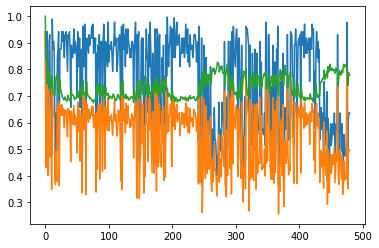

In [28]:
adapt_dict.keys(), adapt_dict[list(adapt_dict.keys())[0]].keys()

plt.plot(act_dict[list(act_dict.keys())[6]][list(act_dict[list(act_dict.keys())[6]].keys())[8]][2.480493528013555])
plt.plot(adp_act_dict[list(adp_act_dict.keys())[6]][list(adp_act_dict[list(adp_act_dict.keys())[6]].keys())[8]][2.480493528013555])
plt.plot(adapt_dict[list(adapt_dict.keys())[6]][list(adapt_dict[list(adapt_dict.keys())[6]].keys())[8]][2.480493528013555])

In [29]:
blocks = [5]
adaptdict[adaptdict['block'].isin(blocks)].filter(regex=("adapt_[0-9.]+_{}[0-9]+".format(octtw))).T

,1920,1921,1922,1923,1924,1925,1926,1927,1928,1929,...,2390,2391,2392,2393,2394,2395,2396,2397,2398,2399
adapt_7.643856189774724_2.3549626459296964,1.0,0.883087,0.836407,0.889450,0.820352,0.795839,0.794710,0.773114,0.755247,0.806431,...,0.756834,0.782172,0.759953,0.751882,0.751604,0.788066,0.763722,0.810217,0.789788,0.759080
adapt_7.664387112768902_2.3549626459296964,1.0,0.882177,0.835214,0.888372,0.819040,0.794421,0.793190,0.771583,0.753730,0.804885,...,0.755182,0.780476,0.758297,0.750249,0.749965,0.786401,0.762068,0.808617,0.788107,0.757474
adapt_7.68491803576308_2.3549626459296964,1.0,0.881268,0.834026,0.887291,0.817731,0.793008,0.791673,0.770058,0.752223,0.803341,...,0.753536,0.778783,0.756647,0.748624,0.748335,0.784738,0.760420,0.807017,0.786427,0.755874
adapt_7.705448958757258_2.3549626459296964,1.0,0.880361,0.832841,0.886206,0.816426,0.791601,0.790162,0.768540,0.750724,0.801798,...,0.751898,0.777093,0.755005,0.747006,0.746712,0.783078,0.758778,0.805417,0.784750,0.754282
adapt_7.725979881751436_2.3549626459296964,1.0,0.879457,0.831661,0.885119,0.815125,0.790200,0.788654,0.767029,0.749234,0.800256,...,0.750267,0.775407,0.753369,0.745397,0.745098,0.781421,0.757143,0.803817,0.783076,0.752697
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
adapt_12.468623093406531_2.3549626459296964,1.0,0.910431,0.879831,0.787470,0.829227,0.834422,0.819436,0.827309,0.833862,0.770315,...,0.813500,0.787316,0.809792,0.818371,0.818849,0.780851,0.805845,0.758137,0.779578,0.810159
adapt_12.489154016400711_2.3549626459296964,1.0,0.911332,0.881032,0.788360,0.830456,0.835822,0.820956,0.828869,0.835447,0.771823,...,0.815229,0.789042,0.811505,0.820084,0.820571,0.782537,0.807546,0.759677,0.781234,0.811811
adapt_12.509684939394887_2.3549626459296964,1.0,0.912230,0.882230,0.789260,0.831685,0.837221,0.822476,0.830428,0.837028,0.773337,...,0.816956,0.790770,0.813217,0.821794,0.822289,0.784226,0.809247,0.761225,0.782893,0.813461
adapt_12.530215862389065_2.3549626459296964,1.0,0.913125,0.883425,0.790170,0.832915,0.838619,0.823995,0.831984,0.838606,0.774857,...,0.818681,0.792500,0.814927,0.823501,0.824005,0.785917,0.810946,0.762780,0.784554,0.815110


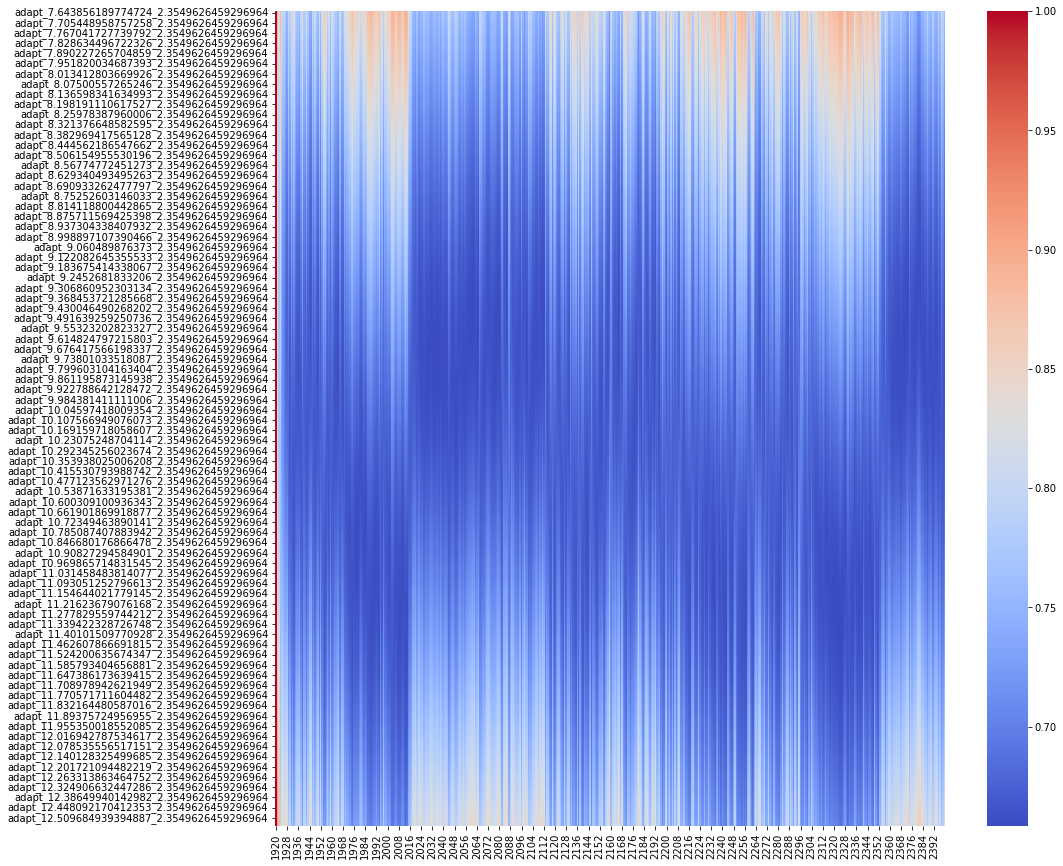

In [30]:
import seaborn as sns

blocks = [5]

f, ax = plt.subplots(figsize=(15, 15))

ax = sns.heatmap(adaptdict[adaptdict['block'].isin(blocks)].filter(regex=("adapt_[0-9.]+_{}[0-9]+".format(octtw))).T, cmap='coolwarm')

## translate to adaptation + predictions by hrf + tw + sigma

In [43]:
# create dict with our settings
c = {}
c['c_prc'] = {}

# set our number of levels
c['c_prc']['n_levels']   = 3

# define the priors for all levels
c['c_prc']['mu_0mu'] = np.array([99991, 1, 1])
c['c_prc']['mu_0sa'] = np.array([99992, 0, 0])
c['c_prc']['logsa_0mu'] = np.array([99993, np.log(0.1), np.log(0.1)])
c['c_prc']['logsa_0sa'] = np.array([1, 1, 1])

c['c_prc']['rhomu'] = np.array([0, 0, 0])
c['c_prc']['rhosa'] = np.array([0, 0, 0])
c['c_prc']['logkamu'] = np.array([np.log(1), np.log(1)])
c['c_prc']['logkasa'] = np.array([0, 0])

c['c_prc']['ommu'] = np.array([99993, -4, -8])
c['c_prc']['omsa'] = np.array([4**2, 4**2, 4**2])
c['c_prc']['logpiumu'] = np.array([-99993])
c['c_prc']['logpiusa'] = np.array([2**2])

# gather prior settings in vectors
c['c_prc']['priormus'] = np.concatenate([c['c_prc']['mu_0mu'], 
                                        c['c_prc']['logsa_0mu'], 
                                        c['c_prc']['rhomu'], 
                                        c['c_prc']['logkamu'], 
                                        c['c_prc']['ommu'], 
                                        c['c_prc']['logpiumu']], axis=0)
c['c_prc']['priorsas'] = np.concatenate([c['c_prc']['mu_0sa'], 
                                        c['c_prc']['logsa_0sa'], 
                                        c['c_prc']['rhosa'], 
                                        c['c_prc']['logkasa'], 
                                        c['c_prc']['omsa'], 
                                        c['c_prc']['logpiusa']], axis=0)

In [44]:
range_model = gaussian_obs_range_config
range_model = bayes_optimal_range_config

In [45]:
# import Sequence_correlations

# surp_dict            = Sequence_correlations.create_surprisal_dict(pref_range, r, normalize=False)
# prob_dict            = Sequence_correlations.create_probability_dict(surp_dict)

In [46]:
surp_dict = {}
prob_dict = {}
surp_dict_flat = {}
prob_dict_flat = {}

for blk in stim_df['block'].unique():
    
    # do HGFing
    stims = stim_df['frequencies_oct'][stim_df['block'] == blk].to_numpy()

    sim = hgf_sim.simModel(stims, hgf, 
                           np.array([10, 0.1, 1.0, 0.001, -0.001,
                                     -0.1, 0, 0, 0,
                                     0.08, 0.12, 0.12,
                                     3.6, 0.5, 2.5]) ,
                           obs_model=gaussian_obs,
                           obs_pvec=0.00002)

    r = hgf_fit.fitModel(sim['y'],
                         stims,
                         ehgf_config,
                         bayes_optimal_config, 
                         quasinewton_optim_config,
                         obs_range_model=range_model,
                         obs_range_u=pref_range,
                         overwrite_opt=c)

    
    surp_dict[blk]            = Sequence_correlations.create_surprisal_dict(pref_range, r, normalize=False)
    prob_dict[blk]            = Sequence_correlations.create_probability_dict(surp_dict[blk])
    
    # add prefix
    surp_dict_flat[blk] = {f'surp_{k}': v for k, v in surp_dict[blk].items()}
    prob_dict_flat[blk] = {f'prob_{k}': v for k, v in prob_dict[blk].items()}
    

Ignored trials: []

Number of levels (depth) inconsistent with length indicated by 'prc_pvec'
 n_levels: 2
 prc_pvec depth: 3

...

Setting new number of levels to 3
(Make sure no error was made in setting up prc_pvec)
Ignored trials: []
Irregular trials: []

Initializing optimization run...

Optimization terminated successfully.
         Current function value: 494.816803
         Iterations: 28
         Function evaluations: 324
         Gradient evaluations: 36


RESULTS:

Parameter estimates - perceptual model:
 mu_0: 	 [10.79841272  1.          1.        ]
 sa_0: 	 [0.50143953 0.07607533 0.10000008]
 rho: 	 [0. 0. 0.]
 ka: 	 [1. 1.]
 om: 	 [-3.34005958 -8.89810616]
 th: 	 0.00033561642678241947
 pi_u: 	 0.45351320940881196
 al: 	 2.2050074380492113

MODEL QUALITY:
 LME: 	 -495.06290448690066 		 (more is better)
 AIC: 	 980.0617623577018 		 (less is better)
 BIC: 	 981.1675847815679 		 (less is better)
Ignored trials: []

Number of levels (depth) inconsistent with length indicated 

/home/jorvhar/miniconda3/envs/bv_preproc/lib/python3.8/site-packages/HGF-0.1.2-py3.8.egg/HGF/hgf.py:320: RuntimeWarning: overflow encountered in exp
  vv = t[trial] * np.exp(p_dict['ka'][lvl-1]*
/home/jorvhar/miniconda3/envs/bv_preproc/lib/python3.8/site-packages/HGF-0.1.2-py3.8.egg/HGF/hgf.py:324: RuntimeWarning: invalid value encountered in double_scalars
  ww = vv * pim_hat
/home/jorvhar/miniconda3/envs/bv_preproc/lib/python3.8/site-packages/HGF-0.1.2-py3.8.egg/HGF/hgf.py:325: RuntimeWarning: invalid value encountered in double_scalars
  rr = (vv - pi[trial-1, lvl-1]**-1) * pim_hat
/home/jorvhar/miniconda3/envs/bv_preproc/lib/python3.8/site-packages/HGF-0.1.2-py3.8.egg/HGF/hgf.py:291: RuntimeWarning: overflow encountered in exp
  * np.exp(p_dict['ka'][lvl] *
/home/jorvhar/miniconda3/envs/bv_preproc/lib/python3.8/site-packages/HGF-0.1.2-py3.8.egg/HGF/hgf.py:315: RuntimeWarning: invalid value encountered in double_scalars
  0.5 * pi_hat[trial,lvl]**-1 * \
/home/jorvhar/miniconda3/envs

         Current function value: 25.258717
         Iterations: 17
         Function evaluations: 1151
         Gradient evaluations: 127


RESULTS:

Parameter estimates - perceptual model:
 mu_0: 	 [8.39765222 1.         1.        ]
 sa_0: 	 [0.90064339 0.4990685  0.23674395]
 rho: 	 [0. 0. 0.]
 ka: 	 [1. 1.]
 om: 	 [ 0.71880735 -7.07950583]
 th: 	 12403.999363554838
 pi_u: 	 1.8890755689952927
 al: 	 0.5293594477704517

MODEL QUALITY:
 LME: 	 -34.78926653594251 		 (more is better)
 AIC: 	 30.70882248712713 		 (less is better)
 BIC: 	 31.58417231056594 		 (less is better)
Ignored trials: []

Number of levels (depth) inconsistent with length indicated by 'prc_pvec'
 n_levels: 2
 prc_pvec depth: 3

...

Setting new number of levels to 3
(Make sure no error was made in setting up prc_pvec)
Ignored trials: []
Irregular trials: []

Initializing optimization run...



/home/jorvhar/miniconda3/envs/bv_preproc/lib/python3.8/site-packages/HGF-0.1.2-py3.8.egg/HGF/hgf.py:320: RuntimeWarning: overflow encountered in exp
  vv = t[trial] * np.exp(p_dict['ka'][lvl-1]*
/home/jorvhar/miniconda3/envs/bv_preproc/lib/python3.8/site-packages/HGF-0.1.2-py3.8.egg/HGF/hgf.py:324: RuntimeWarning: invalid value encountered in double_scalars
  ww = vv * pim_hat
/home/jorvhar/miniconda3/envs/bv_preproc/lib/python3.8/site-packages/HGF-0.1.2-py3.8.egg/HGF/hgf.py:325: RuntimeWarning: invalid value encountered in double_scalars
  rr = (vv - pi[trial-1, lvl-1]**-1) * pim_hat
/home/jorvhar/miniconda3/envs/bv_preproc/lib/python3.8/site-packages/HGF-0.1.2-py3.8.egg/HGF/hgf.py:291: RuntimeWarning: overflow encountered in exp
  * np.exp(p_dict['ka'][lvl] *
/home/jorvhar/miniconda3/envs/bv_preproc/lib/python3.8/site-packages/HGF-0.1.2-py3.8.egg/HGF/hgf.py:315: RuntimeWarning: invalid value encountered in double_scalars
  0.5 * pi_hat[trial,lvl]**-1 * \
/home/jorvhar/miniconda3/envs

Optimization terminated successfully.
         Current function value: 501.093178
         Iterations: 34
         Function evaluations: 360
         Gradient evaluations: 40


RESULTS:

Parameter estimates - perceptual model:
 mu_0: 	 [10.98865612  1.          1.        ]
 sa_0: 	 [0.10925788 0.04077824 0.09999802]
 rho: 	 [0. 0. 0.]
 ka: 	 [1. 1.]
 om: 	 [ -3.60774629 -10.55653403]
 th: 	 0.00033528540521669516
 pi_u: 	 0.3829658835094703
 al: 	 2.6111986551806545

MODEL QUALITY:
 LME: 	 -501.50558591880565 		 (more is better)
 AIC: 	 992.2280915272172 		 (less is better)
 BIC: 	 993.2892540812915 		 (less is better)
Ignored trials: []

Number of levels (depth) inconsistent with length indicated by 'prc_pvec'
 n_levels: 2
 prc_pvec depth: 3

...

Setting new number of levels to 3
(Make sure no error was made in setting up prc_pvec)
Ignored trials: []
Irregular trials: []

Initializing optimization run...

Optimization terminated successfully.
         Current function value: 531.6413

KeyboardInterrupt: 

In [47]:
hgf_fit.fitModel(sim['y'],
                         stims,
                         123,
                         bayes_optimal_config, 
                         quasinewton_optim_config,
                         obs_range_model=range_model,
                         obs_range_u=pref_range,
                         overwrite_opt=c)

Ignored trials: []
Irregular trials: []


TypeError: 'int' object is not callable

In [62]:
# put in dataframe
preddict = pd.DataFrame()

for k in adapt_dict.keys():
    
    tempdict = pd.DataFrame({**surp_dict_flat[blk], **prob_dict_flat[blk]})
    tempdict = tempdict.assign(block=k)
    
    preddict = pd.concat([preddict, tempdict], ignore_index=True)

In [63]:
preddict

,surp_7.643856189774724,surp_7.664387112768902,surp_7.68491803576308,surp_7.705448958757258,surp_7.725979881751436,surp_7.746510804745614,surp_7.767041727739792,surp_7.78757265073397,surp_7.808103573728148,surp_7.828634496722326,...,prob_12.38649940142982,prob_12.407030324423998,prob_12.427561247418176,prob_12.448092170412353,prob_12.468623093406531,prob_12.489154016400711,prob_12.509684939394887,prob_12.530215862389065,prob_12.550746785383243,block
0,5.383890,5.302889,5.222589,5.142991,5.064094,4.985898,4.908403,4.831609,4.755516,4.680124,...,0.004997,0.004608,0.004247,0.003911,0.003599,0.003310,0.003042,0.002794,0.002564,1.0
1,5.256093,5.175780,5.096175,5.017278,4.939089,4.861608,4.784834,4.708769,4.633411,4.558761,...,0.004054,0.003730,0.003430,0.003152,0.002894,0.002655,0.002435,0.002231,0.002043,1.0
2,5.095515,5.016320,4.937836,4.860066,4.783009,4.706664,4.631032,4.556113,4.481907,4.408413,...,0.003225,0.002961,0.002717,0.002491,0.002282,0.002089,0.001911,0.001747,0.001596,1.0
3,6.250935,6.161741,6.073263,5.985502,5.898457,5.812128,5.726516,5.641620,5.557440,5.473977,...,0.009295,0.008613,0.007974,0.007378,0.006821,0.006302,0.005818,0.005368,0.004949,1.0
4,5.810376,5.724604,5.639551,5.555218,5.471604,5.388708,5.306532,5.225075,5.144337,5.064318,...,0.006102,0.005631,0.005193,0.004785,0.004406,0.004054,0.003728,0.003425,0.003145,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17275,5.232197,5.144786,5.058205,4.972453,4.887530,4.803436,4.720172,4.637736,4.556129,4.475352,...,0.000854,0.000769,0.000693,0.000623,0.000560,0.000503,0.000452,0.000405,0.000363,36.0
17276,5.100489,5.014315,4.928971,4.844456,4.760770,4.677914,4.595887,4.514690,4.434321,4.354783,...,0.000727,0.000654,0.000588,0.000528,0.000474,0.000425,0.000381,0.000341,0.000306,36.0
17277,5.858716,5.765546,5.673205,5.581694,5.491013,5.401161,5.312139,5.223946,5.136584,5.050050,...,0.001703,0.001543,0.001397,0.001264,0.001143,0.001032,0.000931,0.000840,0.000757,36.0
17278,5.884624,5.791208,5.698623,5.606867,5.515941,5.425845,5.336579,5.248143,5.160537,5.073760,...,0.001744,0.001581,0.001431,0.001295,0.001171,0.001058,0.000955,0.000861,0.000776,36.0


Index(['frequencies', 'frequencies_oct', 'timing', 'closest_volume_rel',
       'closest_volume_abs', 'volume_rel', 'volume_abs', 'run', 'block',
       'segment', 'center_freq_a', 'center_freq_b', 'center_freq_a_oct',
       'center_freq_b_oct', 'probability_a', 'probability_b'],
      dtype='object')


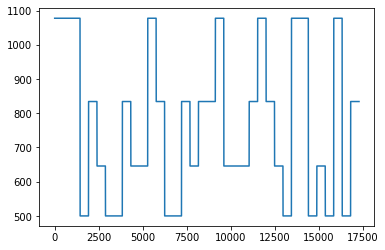

In [64]:
print(stim_df.columns)
plt.plot(stim_df['center_freq_a'])


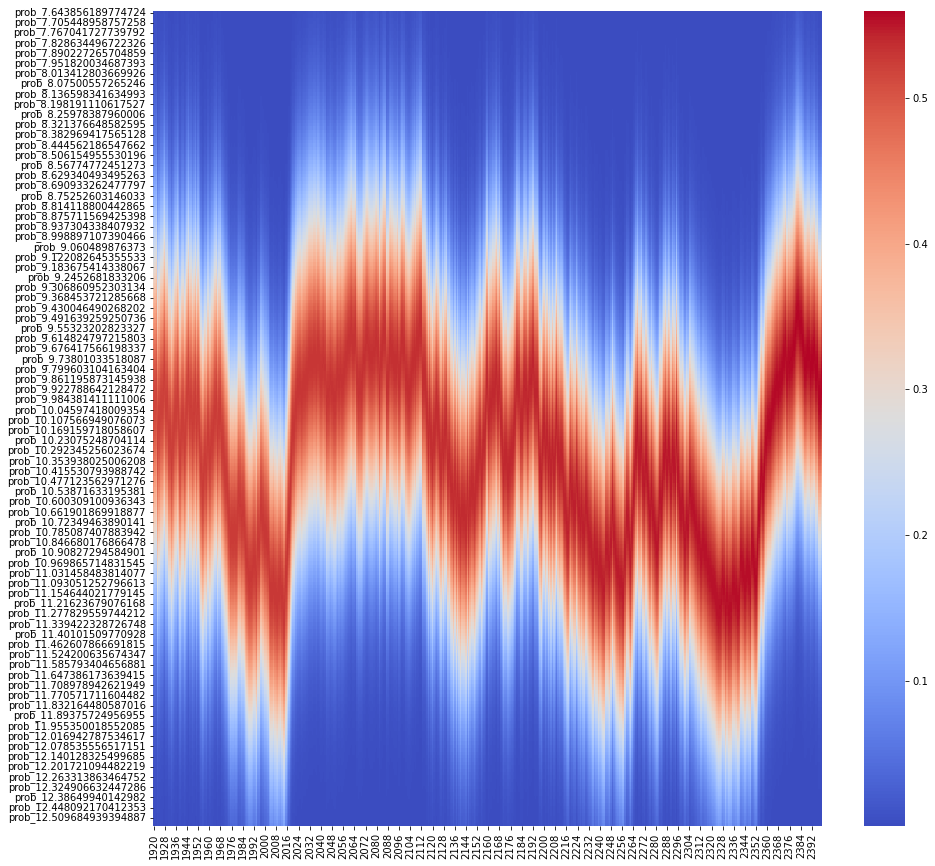

In [65]:
blocks = [5]

f, ax = plt.subplots(figsize=(15, 15))

ax = sns.heatmap(preddict[preddict['block'].isin(blocks)].filter(regex=("prob.*")).T, cmap='coolwarm')

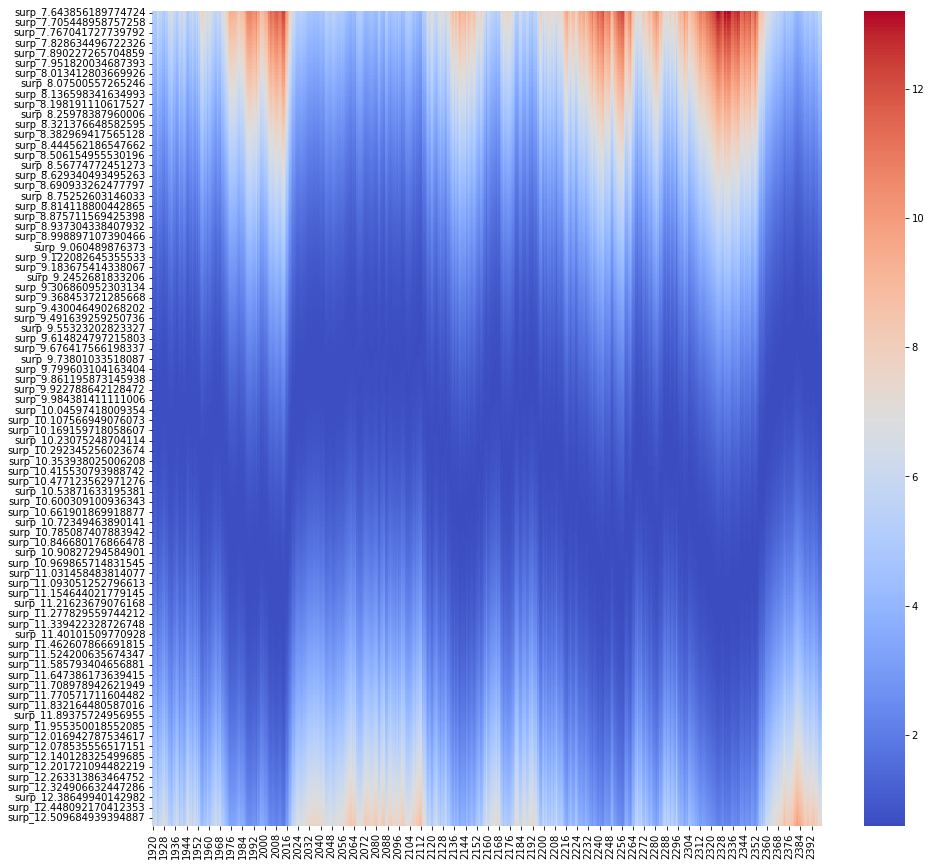

In [66]:
f, ax = plt.subplots(figsize=(15, 15))

ax = sns.heatmap(preddict[preddict['block'].isin(blocks)].filter(regex=("surp.*")).T, cmap='coolwarm')

In [67]:
preddict[preddict['block'].isin([1,2,3])]

,surp_7.643856189774724,surp_7.664387112768902,surp_7.68491803576308,surp_7.705448958757258,surp_7.725979881751436,surp_7.746510804745614,surp_7.767041727739792,surp_7.78757265073397,surp_7.808103573728148,surp_7.828634496722326,...,prob_12.38649940142982,prob_12.407030324423998,prob_12.427561247418176,prob_12.448092170412353,prob_12.468623093406531,prob_12.489154016400711,prob_12.509684939394887,prob_12.530215862389065,prob_12.550746785383243,block
0,5.383890,5.302889,5.222589,5.142991,5.064094,4.985898,4.908403,4.831609,4.755516,4.680124,...,0.004997,0.004608,0.004247,0.003911,0.003599,0.003310,0.003042,0.002794,0.002564,1.0
1,5.256093,5.175780,5.096175,5.017278,4.939089,4.861608,4.784834,4.708769,4.633411,4.558761,...,0.004054,0.003730,0.003430,0.003152,0.002894,0.002655,0.002435,0.002231,0.002043,1.0
2,5.095515,5.016320,4.937836,4.860066,4.783009,4.706664,4.631032,4.556113,4.481907,4.408413,...,0.003225,0.002961,0.002717,0.002491,0.002282,0.002089,0.001911,0.001747,0.001596,1.0
3,6.250935,6.161741,6.073263,5.985502,5.898457,5.812128,5.726516,5.641620,5.557440,5.473977,...,0.009295,0.008613,0.007974,0.007378,0.006821,0.006302,0.005818,0.005368,0.004949,1.0
4,5.810376,5.724604,5.639551,5.555218,5.471604,5.388708,5.306532,5.225075,5.144337,5.064318,...,0.006102,0.005631,0.005193,0.004785,0.004406,0.004054,0.003728,0.003425,0.003145,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1435,5.232197,5.144786,5.058205,4.972453,4.887530,4.803436,4.720172,4.637736,4.556129,4.475352,...,0.000854,0.000769,0.000693,0.000623,0.000560,0.000503,0.000452,0.000405,0.000363,3.0
1436,5.100489,5.014315,4.928971,4.844456,4.760770,4.677914,4.595887,4.514690,4.434321,4.354783,...,0.000727,0.000654,0.000588,0.000528,0.000474,0.000425,0.000381,0.000341,0.000306,3.0
1437,5.858716,5.765546,5.673205,5.581694,5.491013,5.401161,5.312139,5.223946,5.136584,5.050050,...,0.001703,0.001543,0.001397,0.001264,0.001143,0.001032,0.000931,0.000840,0.000757,3.0
1438,5.884624,5.791208,5.698623,5.606867,5.515941,5.425845,5.336579,5.248143,5.160537,5.073760,...,0.001744,0.001581,0.001431,0.001295,0.001171,0.001058,0.000955,0.000861,0.000776,3.0


In [68]:
preddict.filter(regex=("surp.*"))
preddict.filter(regex=("prob.*"))

,prob_7.643856189774724,prob_7.664387112768902,prob_7.68491803576308,prob_7.705448958757258,prob_7.725979881751436,prob_7.746510804745614,prob_7.767041727739792,prob_7.78757265073397,prob_7.808103573728148,prob_7.828634496722326,...,prob_12.365968478435642,prob_12.38649940142982,prob_12.407030324423998,prob_12.427561247418176,prob_12.448092170412353,prob_12.468623093406531,prob_12.489154016400711,prob_12.509684939394887,prob_12.530215862389065,prob_12.550746785383243
0,0.004590,0.004977,0.005393,0.005840,0.006320,0.006834,0.007384,0.007974,0.008604,0.009278,...,0.005415,0.004997,0.004608,0.004247,0.003911,0.003599,0.003310,0.003042,0.002794,0.002564
1,0.005216,0.005652,0.006120,0.006623,0.007161,0.007738,0.008356,0.009016,0.009722,0.010475,...,0.004402,0.004054,0.003730,0.003430,0.003152,0.002894,0.002655,0.002435,0.002231,0.002043
2,0.006124,0.006629,0.007170,0.007750,0.008371,0.009035,0.009745,0.010503,0.011312,0.012174,...,0.003511,0.003225,0.002961,0.002717,0.002491,0.002282,0.002089,0.001911,0.001747,0.001596
3,0.001929,0.002109,0.002304,0.002515,0.002744,0.002991,0.003258,0.003547,0.003859,0.004195,...,0.010025,0.009295,0.008613,0.007974,0.007378,0.006821,0.006302,0.005818,0.005368,0.004949
4,0.002996,0.003265,0.003554,0.003867,0.004204,0.004568,0.004959,0.005380,0.005832,0.006318,...,0.006608,0.006102,0.005631,0.005193,0.004785,0.004406,0.004054,0.003728,0.003425,0.003145
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17275,0.005342,0.005830,0.006357,0.006926,0.007540,0.008202,0.008914,0.009680,0.010503,0.011386,...,0.000947,0.000854,0.000769,0.000693,0.000623,0.000560,0.000503,0.000452,0.000405,0.000363
17276,0.006094,0.006642,0.007234,0.007872,0.008559,0.009298,0.010093,0.010947,0.011863,0.012845,...,0.000807,0.000727,0.000654,0.000588,0.000528,0.000474,0.000425,0.000381,0.000341,0.000306
17277,0.002855,0.003134,0.003437,0.003766,0.004124,0.004511,0.004931,0.005386,0.005878,0.006409,...,0.001877,0.001703,0.001543,0.001397,0.001264,0.001143,0.001032,0.000931,0.000840,0.000757
17278,0.002782,0.003054,0.003351,0.003673,0.004022,0.004401,0.004812,0.005257,0.005739,0.006259,...,0.001922,0.001744,0.001581,0.001431,0.001295,0.001171,0.001058,0.000955,0.000861,0.000776


## Do the Regression fits

In [98]:
# take 2000 best voxels and take prefferences and tw
mat1 = scipy.io.loadmat('/media/jorvhar/Data/MRIData/PreProc/S02_SES1/Betas/BetasSEP_AC_denoise0_cv1.mat'.format(pp, pp))
frequenciesmat = scipy.io.loadmat('/media/jorvhar/Data/MRIData/PreProc/S02_SES1/Betas/prfmat_full.mat')
hrf = scipy.io.loadmat('/media/jorvhar/Data/MRIData/PreProc/S02_SES1/Betas/hrf.mat')
con_hrf = [hrf['xdata'][0,:], hrf['ydata'][0,:]]

# settings for nr of best voxels
nrvoxels = 1
bestvoxels = np.argpartition(-mat1['FMapTrain'], nrvoxels)[0, :nrvoxels]



In [94]:
frequenciesmat['prfpref_full']

array([[0.],
       [0.],
       [0.],
       ...,
       [0.],
       [0.],
       [0.]])

In [95]:
np.max(bestvoxels)

401523

In [96]:
print(mat1.keys())
print(mat1['FMapTrain'][0, bestvoxels])

dict_keys(['__header__', '__version__', '__globals__', 'InfoVTCTrain', 'trainSounds', 'FMapTrain', 'BetasSEPTrain', 'InfoVTCTest', 'testSounds', 'BetasSEPTest', 'InfoPRTSEPTrain', 'InfoPRTSEPTest'])
[5.17720989 5.19823025 5.61848668 ... 4.9799816  4.97931856 4.97606128]


(array([  9.,  46., 404., 895., 521.,  85.,  24.,  12.,   3.,   1.]),
 array([-4.74208058, -3.39312604, -2.0441715 , -0.69521696,  0.65373758,
         2.00269212,  3.35164666,  4.7006012 ,  6.04955574,  7.39851028,
         8.74746482]),
 <BarContainer object of 10 artists>)

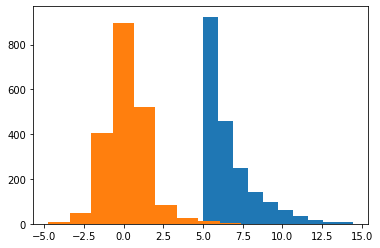

In [97]:
# subsample highest 2000
plt.hist(mat1['FMapTrain'][0, bestvoxels])

# get all f values
np.random.choice(mat1['FMapTrain'].shape[1], 2000, replace=False)
plt.hist(mat1['FMapTrain'][0, np.random.choice(mat1['FMapTrain'].shape[1], 2000, replace=False)])

#### get frequencie prefferences for our best voxels

(array([ 36., 166., 119., 165., 284., 503., 580.,  84.,  34.,  29.]),
 array([ 7.64385619,  8.13454525,  8.62523431,  9.11592337,  9.60661243,
        10.09730149, 10.58799055, 11.07867961, 11.56936867, 12.06005773,
        12.55074679]),
 <BarContainer object of 10 artists>)

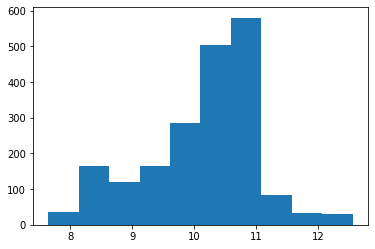

In [98]:
plt.hist(frequenciesmat['prfpref_full'][bestvoxels])

(array([342., 188., 158., 110.,  81.,  60.,  75.,  76.,  90., 820.]),
 array([0.74049652, 0.96264548, 1.18479443, 1.40694339, 1.62909235,
        1.8512413 , 2.07339026, 2.29553921, 2.51768817, 2.73983713,
        2.96198608]),
 <BarContainer object of 10 artists>)

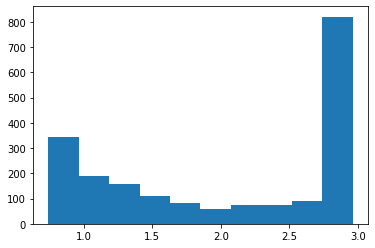

In [99]:
plt.hist(frequenciesmat['prftw_full'][bestvoxels])

### fitting

In [100]:
adaptdict.filter(regex=("acti_.*"))

,acti_7.643856189774724,acti_7.664387112768902,acti_7.68491803576308,acti_7.705448958757258,acti_7.725979881751436,acti_7.746510804745614,acti_7.767041727739792,acti_7.78757265073397,acti_7.808103573728148,acti_7.828634496722326,...,acti_12.365968478435642,acti_12.38649940142982,acti_12.407030324423998,acti_12.427561247418176,acti_12.448092170412353,acti_12.468623093406531,acti_12.489154016400711,acti_12.509684939394887,acti_12.530215862389065,acti_12.550746785383243
0,"[0.6973480753579487, 0.7171217800348706, 0.254...","[0.7022421148883378, 0.721953812688135, 0.2575...","[0.7071220560269387, 0.7267686129147496, 0.261...","[0.7119871298734219, 0.7315654039085042, 0.264...","[0.7168365652769262, 0.7363434074228861, 0.268...","[0.721669589032609, 0.7411018439755305, 0.2718...","[0.72648542608025, 0.7458399330544381, 0.27550...","[0.7312832997048374, 0.7505568933258855, 0.279...","[0.7360624317390676, 0.7552519428439546, 0.282...","[0.74082204276769, 0.7599242992616047, 0.28662...",...,"[0.5734367776203404, 0.5531631826679854, 0.969...","[0.5684335564408252, 0.5481843943446598, 0.967...","[0.5634353871318316, 0.5432132023147552, 0.965...","[0.5584429070670143, 0.5382502157119038, 0.963...","[0.5534567468300716, 0.5332960364465923, 0.961...","[0.5484775301028847, 0.5283512591079741, 0.958...","[0.5435058735570037, 0.5234164708690778, 0.956...","[0.5385423867485004, 0.5184922513954218, 0.954...","[0.5335876720161888, 0.5135791727570328, 0.951...","[0.5286423243832428, 0.5086777993438876, 0.949..."
1,"[0.6703706618493117, 0.6914923877603084, 0.218...","[0.6755923079861912, 0.6966635992240496, 0.222...","[0.6808028793377121, 0.7018201380429415, 0.225...","[0.6860014953930275, 0.7069611088848499, 0.228...","[0.6911872716204669, 0.7120856133876895, 0.232...","[0.6963593197067651, 0.7171927504113367, 0.235...","[0.7015167477995486, 0.7222816162924386, 0.239...","[0.7066586607529971, 0.7273513051020206, 0.242...","[0.7117841603765886, 0.732400908905796, 0.2463...","[0.7168923456868401, 0.7374295180270776, 0.249...",...,"[0.5395746391834091, 0.518451676570537, 0.9663...","[0.5343540937042829, 0.5132771301653201, 0.964...","[0.5291438388288812, 0.5081156083184832, 0.961...","[0.5239445623498381, 0.5029677606952833, 0.959...","[0.5187569428367681, 0.4978342273015404, 0.957...","[0.5135816495216128, 0.49271563838791965, 0.95...","[0.5084193421886485, 0.4876126143588717, 0.951...","[0.503270671069162, 0.4825257656862327, 0.9492...","[0.498136276740787, 0.47745569282746275, 0.946...","[0.49301679003151294, 0.47240298614853043, 0.9..."
2,"[0.6369523012118541, 0.6596323597570204, 0.180...","[0.64255080371947, 0.6651987132972952, 0.18316...","[0.6481429501481463, 0.6707545362388305, 0.186...","[0.6537277222802784, 0.6762987841499547, 0.189...","[0.6593040949854644, 0.681830406910094, 0.1927...","[0.6648710365139473, 0.6873483490243006, 0.195...","[0.6704275087954231, 0.6928515499426764, 0.199...","[0.6759724677431032, 0.6983389443845732, 0.202...","[0.6815048635629217, 0.7038094626674376, 0.205...","[0.6870236410677699, 0.7092620310401676, 0.209...",...,"[0.49864391072138714, 0.47668303353141345, 0.9...","[0.49320587326960225, 0.4713204696176045, 0.95...","[0.4877853241503262, 0.46597828565940874, 0.95...","[0.48238299536182727, 0.4606571613440434, 0.95...","[0.47699960616686865, 0.455357763241315, 0.951...","[0.47163586298850263, 0.4500807447261626, 0.94...","[0.4662924593124954, 0.44482674590771076, 0.94...","[0.46097007559636116, 0.43959639356479746, 0.9...","[0.4556693791849683, 0.43439030108792387, 0.93...","[0.4503910242327023, 0.42920906842759976, 0.93..."
3,"[0.5945840434204855, 0.6190519334948072, 0.138...","[0.6006116929846945, 0.6250768929938518, 0.141...","[0.6066405054711407, 0.6310981311570023, 0.144...","[0.6126692952623612, 0.6371144165919131, 0.147...","[0.618696864906131, 0.6431245075812217, 0.1498...","[0.6247220054734293, 0.6491271524771792, 0.152...","[0.6307434969256435, 0.6551210901049539, 0.155...","[0.63676010849088, 0.66

ValueError: setting an array element with a sequence.

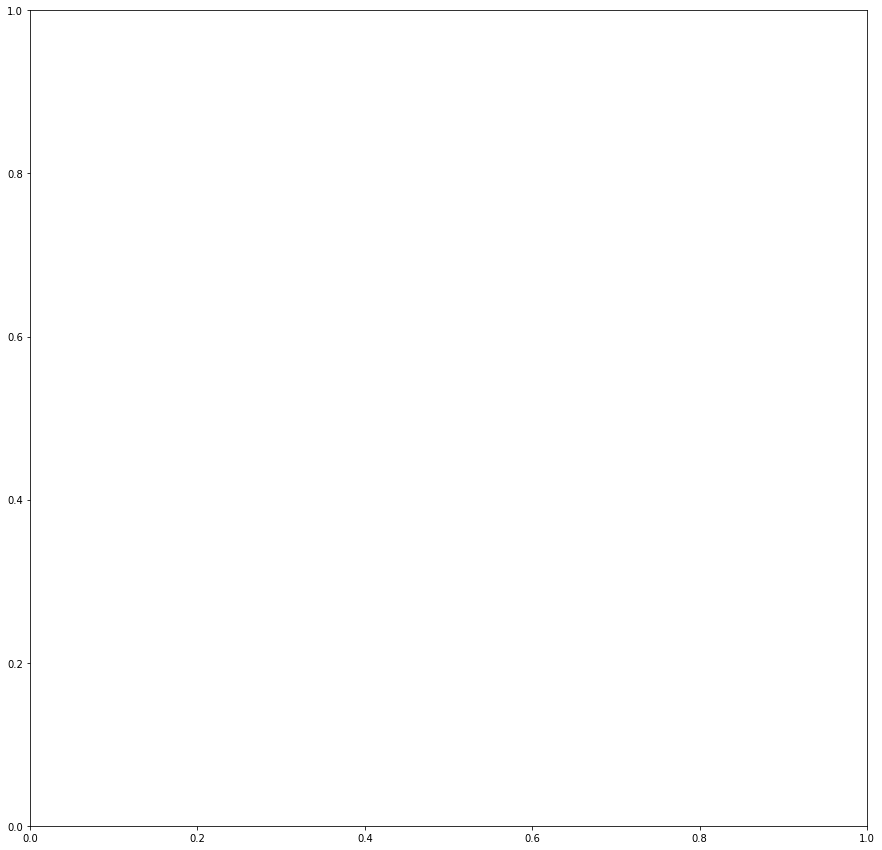

In [101]:
blocks = [5]

f, ax = plt.subplots(figsize=(15, 15))

ax = sns.heatmap(adaptdict[adaptdict['block'].isin(blocks)].filter(regex=("acti.*")).T, cmap='coolwarm')

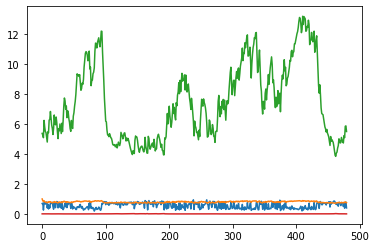

In [99]:
plt.plot(act_dict[blk][7.643856189774724][2.480493528013555])
plt.plot(adapt_dict[blk][7.643856189774724][2.480493528013555])
plt.plot(surp_dict[blk][7.643856189774724])
plt.plot(prob_dict[blk][7.643856189774724])

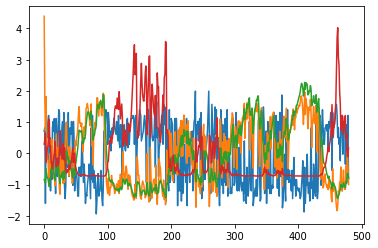

In [100]:
plt.plot(  scipy.stats.zscore(act_dict[blk][7.643856189774724][2.480493528013555])  )
plt.plot(  scipy.stats.zscore(adapt_dict[blk][7.643856189774724][2.480493528013555])  )
plt.plot(  scipy.stats.zscore(surp_dict[blk][7.643856189774724])  )
plt.plot(  scipy.stats.zscore(prob_dict[blk][7.643856189774724])  )

In [101]:
acti = np.array([])
adap = np.array([])
pred = np.array([])
surp = np.array([])

for blk in act_dict.keys():
    acti.append()

AttributeError: 'numpy.ndarray' object has no attribute 'append'

### HRF things

In [27]:
def normalize(data):
    return (data - np.min(data)) / (np.max(data) - np.min(data))

def find_padding(tr, ntrials, tlen):
    padding = 0
    notdiv = int(ntrials*tlen*10) % int(tr*10)
    while notdiv != 0:
        padding += 1
        newlen = ntrials + padding
        # check if modulated by 10 is whole number 
        if (newlen*tlen*10).is_integer():
            notdiv = int(newlen*tlen*10) % int(tr*10)
        if padding > 100000: 
            raise Exception("Sorry, padding not possible") 
    return(padding)

In [28]:
# hrf and stim lengts
trialleng = stim_df['timing'].diff()[1]
con_hrf_vollen = np.diff(con_hrf[0])[0]

# interpolate
xnew = np.arange(np.min(con_hrf[0]), np.max(con_hrf[0]), trialleng)
f = scipy.interpolate.interp1d(con_hrf[0], con_hrf[1], kind='cubic')
newhrf = normalize(f(xnew))
plt.plot(normalize(f(xnew)))

NameError: name 'con_hrf' is not defined

In [29]:
newhrf

NameError: name 'newhrf' is not defined

In [105]:

newpadding = find_padding(1.8, 480, 0.25)


xpredz_dict = {}

for blk in act_dict.keys():
    
    xpredz_dict[blk] = {}
    
    for frq in act_dict[blk].keys():
        
        xpredz_dict[blk][frq] = {}
        
        for tw in act_dict[blk][frq].keys():
            
    
            xpredz = np.empty([4, 480])

            xpredz[0, :] = scipy.stats.zscore(act_dict[blk][frq][tw])
            xpredz[1, :] = scipy.stats.zscore(adapt_dict[blk][frq][tw])
            xpredz[2, :] = scipy.stats.zscore(surp_dict[blk][frq])
            xpredz[3, :] = scipy.stats.zscore(prob_dict[blk][frq])

            xpredz = np.nan_to_num(xpredz)
            
            # make dimensions match up
            xpredz = np.pad(xpredz, [(0, 0), (0, newpadding)], mode='constant')

            # then convolve and resample
            convoled = scipy.signal.convolve(xpredz, np.tile(newhrf, (4, 1)), mode='same')
            resampled_convolved = np.transpose(scipy.signal.resample(np.transpose(convoled), int((convoled.shape[1]*0.25)/1.8)))

            # save in dict
            xpredz_dict[blk][frq][tw] = resampled_convolved



In [106]:
xpredz_dict[1].keys()
xpredz_dict[1][7.643856189774724].keys()

dict_keys([2.480493528013555, 2.3549626459296964, 2.2174591221797617, 2.0654560287347112, 1.895531027292399, 1.702885949350003, 1.4804935280135552, 1.2174591221797617, 0.8955310272923991, 0.48049352801355516])

In [107]:
resampled_convolved

array([[ 2.47958381e+00,  3.44497176e+00,  1.11003326e+00,
        -6.84018649e-01, -3.07689178e+00, -9.52118374e+00,
        -1.29150065e+01, -8.81658900e+00, -2.14562839e+00,
         2.61523327e+00,  5.06219984e+00,  6.38378127e+00,
         6.78806608e+00,  6.78851545e+00,  6.26431143e+00,
         6.15814959e+00,  4.61691916e+00,  3.35463064e+00,
         3.67899433e+00,  4.57417580e+00,  3.49665968e+00,
         3.08230984e+00,  2.97269129e+00, -5.68388530e-02,
        -2.38832572e+00, -2.63014620e+00, -2.37228037e-01,
         1.68438589e+00,  2.43914038e+00,  3.31591237e+00,
         4.70373592e+00,  4.25616724e+00,  1.53880266e+00,
         6.33168004e-01,  7.32838915e-01,  1.04511511e+00,
         1.38859154e+00, -9.66348527e-01, -4.12328615e+00,
        -6.85269872e+00, -8.24595605e+00, -6.92513344e+00,
        -5.26019168e+00, -3.47817260e+00, -3.39515932e-01,
        -1.12210133e+00, -4.79920579e+00, -4.35587165e+00,
        -2.67349851e+00, -3.25609898e+00, -9.22808604e+0

In [129]:
resampled_convolved

array([[ 2.47958381e+00,  3.44497176e+00,  1.11003326e+00,
        -6.84018649e-01, -3.07689178e+00, -9.52118374e+00,
        -1.29150065e+01, -8.81658900e+00, -2.14562839e+00,
         2.61523327e+00,  5.06219984e+00,  6.38378127e+00,
         6.78806608e+00,  6.78851545e+00,  6.26431143e+00,
         6.15814959e+00,  4.61691916e+00,  3.35463064e+00,
         3.67899433e+00,  4.57417580e+00,  3.49665968e+00,
         3.08230984e+00,  2.97269129e+00, -5.68388530e-02,
        -2.38832572e+00, -2.63014620e+00, -2.37228037e-01,
         1.68438589e+00,  2.43914038e+00,  3.31591237e+00,
         4.70373592e+00,  4.25616724e+00,  1.53880266e+00,
         6.33168004e-01,  7.32838915e-01,  1.04511511e+00,
         1.38859154e+00, -9.66348527e-01, -4.12328615e+00,
        -6.85269872e+00, -8.24595605e+00, -6.92513344e+00,
        -5.26019168e+00, -3.47817260e+00, -3.39515932e-01,
        -1.12210133e+00, -4.79920579e+00, -4.35587165e+00,
        -2.67349851e+00, -3.25609898e+00, -9.22808604e+0

In [131]:
muarray[6]

array([ 7.64385619,  7.66438711,  7.68491804,  7.70544896,  7.72597988,
        7.7465108 ,  7.76704173,  7.78757265,  7.80810357,  7.8286345 ,
        7.84916542,  7.86969634,  7.89022727,  7.91075819,  7.93128911,
        7.95182003,  7.97235096,  7.99288188,  8.0134128 ,  8.03394373,
        8.05447465,  8.07500557,  8.0955365 ,  8.11606742,  8.13659834,
        8.15712926,  8.17766019,  8.19819111,  8.21872203,  8.23925296,
        8.25978388,  8.2803148 ,  8.30084573,  8.32137665,  8.34190757,
        8.36243849,  8.38296942,  8.40350034,  8.42403126,  8.44456219,
        8.46509311,  8.48562403,  8.50615496,  8.52668588,  8.5472168 ,
        8.56774772,  8.58827865,  8.60880957,  8.62934049,  8.64987142,
        8.67040234,  8.69093326,  8.71146419,  8.73199511,  8.75252603,
        8.77305695,  8.79358788,  8.8141188 ,  8.83464972,  8.85518065,
        8.87571157,  8.89624249,  8.91677342,  8.93730434,  8.95783526,
        8.97836618,  8.99889711,  9.01942803,  9.03995895,  9.06

In [ ]:
tw = octgrid[-2]
frq = muarray[100]

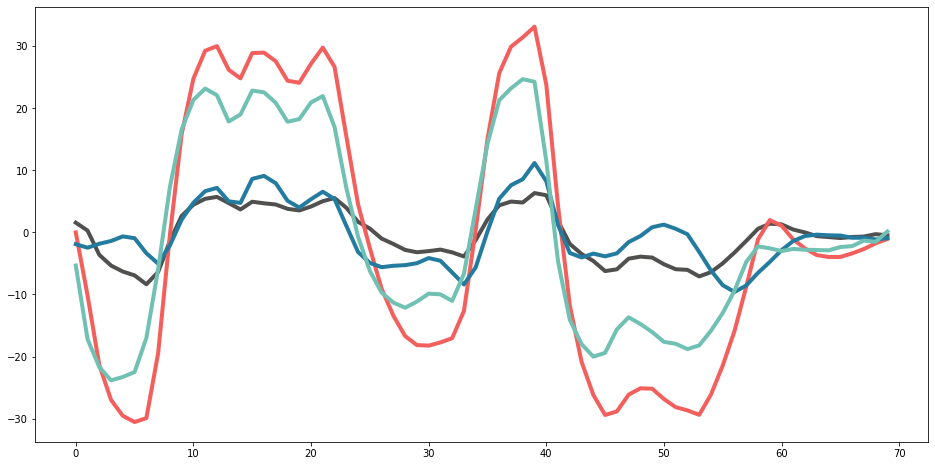

In [211]:
blk = 5
tw = octgrid[-2]
frq = muarray[100]

plt.figure(figsize=(16, 8))

sign = scipy.signal.resample(np.transpose(xpredz_dict[blk][frq][tw]), int((convoled.shape[1]*0.25)/1.8))


# activation
line, = plt.plot( sign[:,0], lw=4)
line.set_color('#50514F')

# adaptation
line, = plt.plot( sign[:,1], lw=4)
line.set_color('#F25F5C')

# surprisal
line, = plt.plot( sign[:,2], lw=4)
line.set_color('#247BA0')

# probability
line, = plt.plot( sign[:,3], lw=4)
line.set_color('#70C1B3')

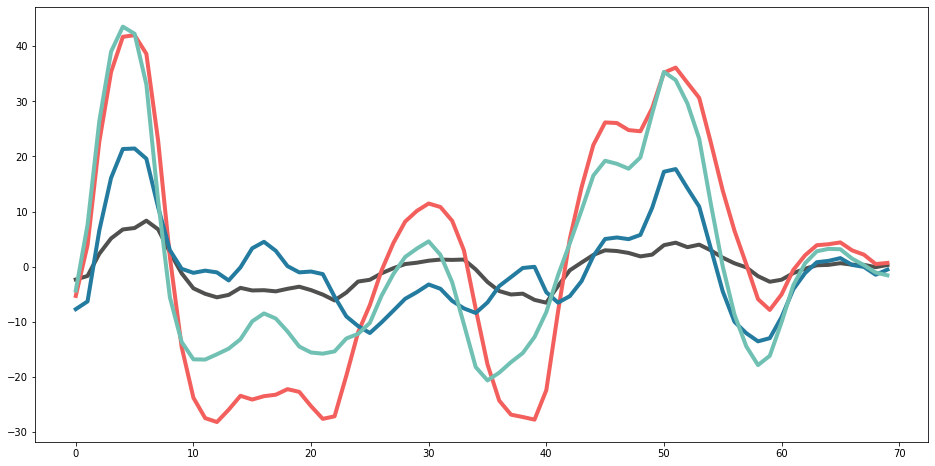

In [212]:
blk = 5
tw = octgrid[0]
frq = muarray[-25]

plt.figure(figsize=(16, 8))

sign = scipy.signal.resample(np.transpose(xpredz_dict[blk][frq][tw]), int((convoled.shape[1]*0.25)/1.8))


# activation
line, = plt.plot( sign[:,0], lw=4)
line.set_color('#50514F')

# adaptation
line, = plt.plot( sign[:,1], lw=4)
line.set_color('#F25F5C')

# surprisal
line, = plt.plot( sign[:,2], lw=4)
line.set_color('#247BA0')

# probability
line, = plt.plot( sign[:,3], lw=4)
line.set_color('#70C1B3')

In [71]:
pp = 2
mat = scipy.io.loadmat('/media/jorvhar/Data/MRIData/timing data/data/{}/{}-mainpred.mat'.format(pp, pp))
stimuli = scipy.io.loadmat('/media/jorvhar/Data/MRIData/timing data/stimuli/{}/{}_main_stims.mat'.format(pp, pp))

blocknr = 5
idxblock = np.where(mat['timingz'][1] == blocknr) # where block is 1

#get frequency presentation data for block
frequencies = stimuli['pres_freq'][blocknr-1, :]

# other values
tps = np.sum(mat['timingz'][3, idxblock] == 1) # get trials per secion

#get timings back from mat file, substract begin time
timings = mat['timingz'][4, idxblock] - np.min(mat['timingz'][4, idxblock]) 

matidx = np.where(mat['segmentz'][1] == blocknr)

centa = 2**np.repeat(mat['segmentz'][7][matidx], tps)   # cent freq a
centb = 2**np.repeat(mat['segmentz'][8][matidx], tps)  # cent freq b
proba = np.repeat(mat['segmentz'][5][matidx], tps)  # prob a
probb = np.repeat(mat['segmentz'][6][matidx], tps)  # prob b


In [170]:
muarray[10]

7.8491654197165035

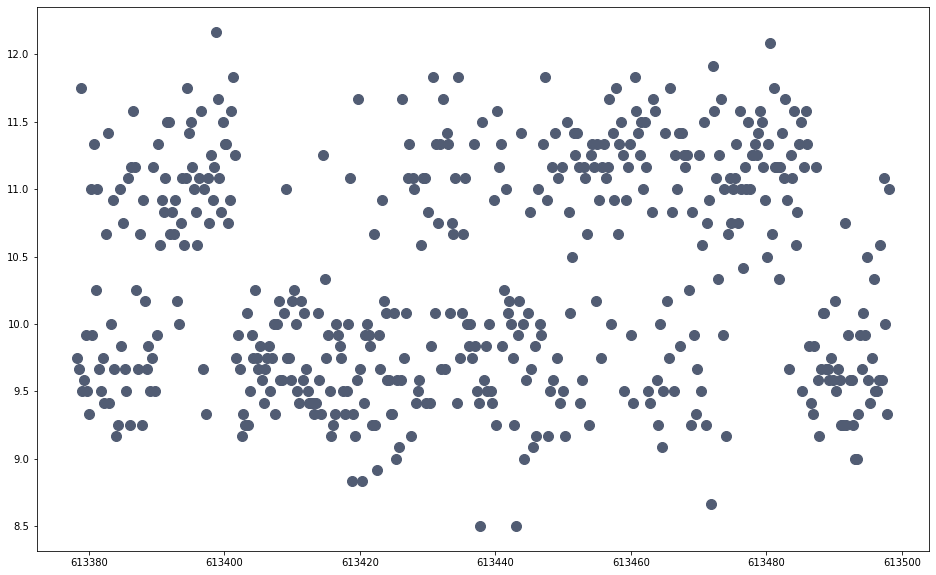

In [70]:
# senatry check the data
# fig, ax = plt.subplots(1, 1, gridspec_kw={'height_ratios': [3, 1]}, figsize=(12, 8))
fig, ax = plt.subplots(1, figsize=(16, 10))

#ax.axhline(y=muarray[100], color='#8E8F8D', linestyle='--', lw=6, alpha=0.8)
#ax.axhline(y=muarray[-25], color='#8E8F8D', linestyle='--', lw=6, alpha=0.8)
ax.scatter(timings, np.log2(frequencies), color='#515C73', s=100)


# ax[1].plot(proba, color='r')
# ax[1].plot(probb, color='g')


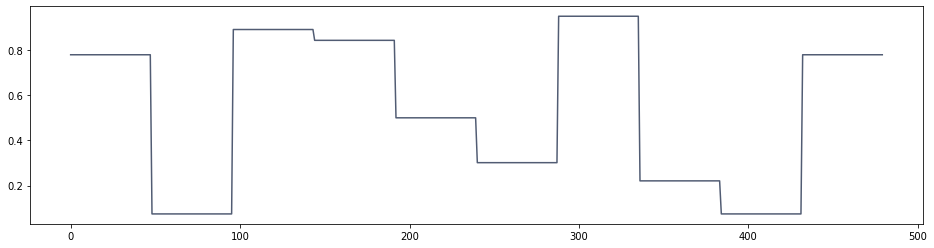

In [72]:
# senatry check the data
# fig, ax = plt.subplots(1, 1, gridspec_kw={'height_ratios': [3, 1]}, figsize=(12, 8))
fig, ax = plt.subplots(1, figsize=(16, 4))

ax.plot(probb, color='#515C73')

In [82]:
mat['segmentz'][5][::48]

# structure increase vs structure decrease
# where .5 is lowest structure edges are highest crusture
structure = np.abs(mat['segmentz'][5][::48] - 0.5) * 2
structdif = np.diff(structure)

In [246]:
baseline_inc = np.zeros(2*48)
baseline_inc[:] = np.nan
baseline_inc[0] = 0.1

# calculate baseline global power increase
for i in np.arange(1, 49):
    baseline_inc[i] = baseline_inc[i-1] + (1/((i+3)**1.6))
      
# increases and decreases
all_inc = np.zeros((6, 2* 48))
all_inc[:, :48] = baseline_inc[:48]
for i in range(len(all_inc)):
    all_inc[i, 48:] = baseline_inc[48] + -(((i-2.5)/5)  *  baseline_inc[0:48]) 
    all_inc[i, :] += np.random.normal(0, 0.01, 2*48)
    
# add noise
baseline_inc += np.random.normal(0, 0.01, 2*48)

In [247]:
def hex_to_rgb(value):
    value = value.lstrip('#')
    lv = len(value)
    return tuple(int(value[i:i + lv // 3], 16) for i in range(0, lv, lv // 3))

def rgb_to_int(value):
    return tuple( np.round(value[i]/255, 3) for i in range(3) )

def rgb_to_hex(rgb):
    return '#%02x%02x%02x' % rgb

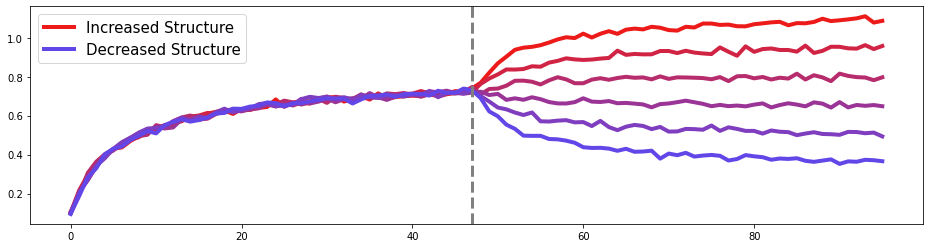

In [253]:
fig, ax = plt.subplots(1, figsize=(16, 4))

colorrange = ['#6346E8', '#7F3DBF', '#9A3496', '#B62C6C', '#D12343', '#ED1A1A']
colorrange = colorrange[::-1]
labels = ['Increased Structure', '', '', '', '', 'Decreased Structure']

for i in range(6):
    ax.plot(all_inc[i, :], color= colorrange[i], lw=4, label=labels[i])

ax.legend(fontsize=15)

plt.axvline(x=47, lw=3, c='grey', ls='--')


# ax.plot(baseline_inc)

In [223]:
abc = hex_to_rgb('#6346E8')
rgb_to_int(hex_to_rgb('#6346E8'))

(0.388, 0.275, 0.91)

In [141]:
scipy.signal.resample(np.transpose(xpredz_dict[blk][frq][tw]), int((convoled.shape[1]*0.25)/1.8))

array([[ -1.8889623 ,  -4.88411107,  -8.08523168,  -5.6470241 ],
       [ -0.15620019,   5.15548697,  -5.39100777,   6.05745437],
       [  4.6709958 ,  24.42800981,   9.20014898,  25.70697159],
       [  7.17093464,  36.4394441 ,  18.65437627,  37.85067185],
       [  8.68493431,  42.61198195,  24.04913245,  43.75623837],
       [  9.21368878,  43.20096971,  24.47574268,  43.65616669],
       [ 10.16109244,  39.61744824,  22.16785699,  35.12412237],
       [  7.54719429,  23.1231058 ,  11.50814071,  12.53666934],
       [  1.82635177,   0.62916797,   1.45435828,  -8.07034627],
       [ -3.46955439, -17.21159695,  -3.52570602, -17.87003934],
       [ -6.07281903, -26.42485828,  -3.88406202, -18.72551378],
       [ -6.47024495, -29.57367686,  -2.61964999, -16.37408235],
       [ -6.23601637, -29.41103923,  -2.06644388, -13.96269095],
       [ -4.92035947, -26.21891895,  -3.09568184, -14.08997894],
       [ -4.09781163, -24.17814322,  -0.7403319 , -14.90361522],
       [ -6.09941308, -26

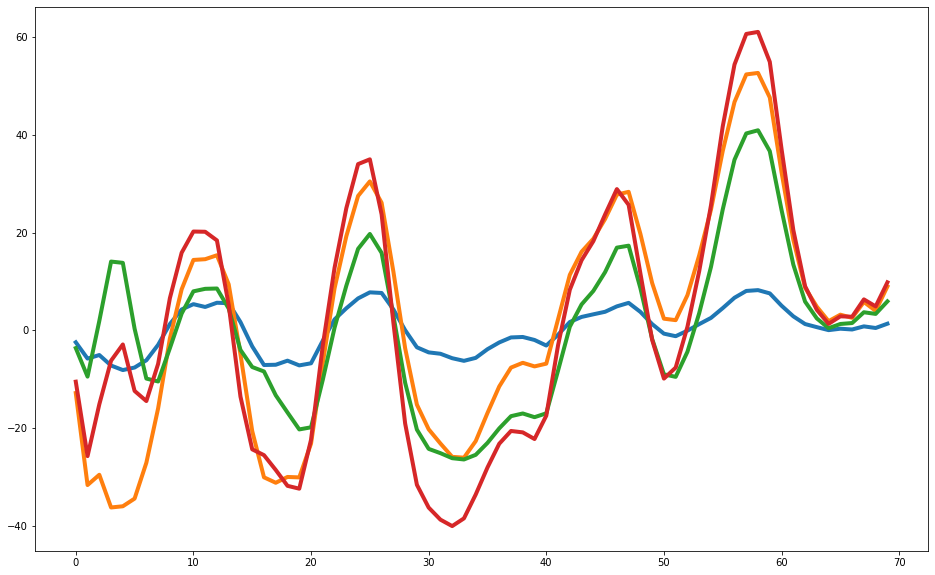

In [128]:
plt.figure(figsize=(16, 10))

plt.plot(scipy.signal.resample(np.transpose(xpredz_dict[1][7.643856189774724][1.4804935280135552]), int((convoled.shape[1]*0.25)/1.8)),
         lw=4)

In [110]:
stim_df.keys()

Index(['frequencies', 'frequencies_oct', 'timing', 'closest_volume_rel',
       'closest_volume_abs', 'volume_rel', 'volume_abs', 'run', 'block',
       'segment', 'center_freq_a', 'center_freq_b', 'center_freq_a_oct',
       'center_freq_b_oct', 'probability_a', 'probability_b'],
      dtype='object')

In [111]:
rundict = {}
volumes=240

# FULL RUN DICTIONARY


for currun in stim_df['run'].unique():
    
    rundict[currun] = {}
    
    for frq in act_dict[1].keys():

        rundict[currun][frq] = {}

        for tw in act_dict[blk][frq].keys():

 
    

            runarray = np.zeros([4, volumes])

            for blk in stim_df['block'][stim_df['run'] == currun].unique():

                startidx = stim_df['volume_rel'][stim_df['block'] == blk].to_numpy()[0]
                temparray = xpredz_dict[blk][frq][tw]

                runarray[:, startidx:startidx+temparray.shape[1]] = temparray

            rundict[currun][frq][tw] = runarray
    

In [112]:
# FULL EXP DICTIONARY


fullpred = {}

for frq in act_dict[1].keys():

    fullpred[frq] = {}

    for tw in act_dict[blk][frq].keys():
            
        fullpred[frq][tw] = np.concatenate([rundict[x][frq][tw] for x in rundict], 1)

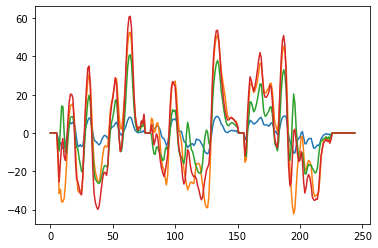

In [113]:
plt.plot(np.transpose(fullpred[7.643856189774724][1.4804935280135552][:, :245]))

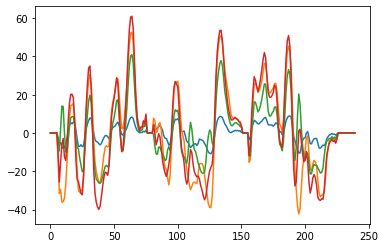

In [114]:
plt.plot(np.transpose(rundict[1][7.643856189774724][1.4804935280135552]))

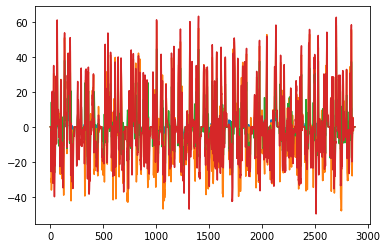

In [115]:
# get predictions for some tw and some tpref over complete exp
plt.plot(np.transpose(fullpred[7.643856189774724][1.4804935280135552]))

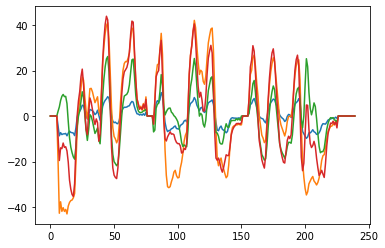

In [116]:
# get predictions for some tw and some tpref over run
plt.plot(np.transpose(rundict[4][7.643856189774724][1.4804935280135552]))

## linear reg

In [117]:
y = np.mean(fullpred[7.643856189774724][1.4804935280135552], axis=0)
y += np.random.normal(0,5,y.shape[0])
x = np.transpose(fullpred[7.643856189774724][1.4804935280135552])

In [118]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn import datasets
from sklearn import svm
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

In [119]:
X_train, X_test, y_train, y_test = train_test_split(x, y, train_size=0.75, test_size=0.25, random_state=0)

In [120]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((2160, 4), (2160,), (720, 4), (720,))

In [121]:
# Create linear regression object
regr = LinearRegression()

# Train the model using the training sets
regr.fit(X_train, y_train)

# Make predictions using the testing set
y_pred = regr.predict(X_test)

# The coefficients
print("Coefficients: \n", regr.coef_)
# The mean squared error
print("Mean squared error: %.2f" % mean_squared_error(y_test, y_pred))
# The coefficient of determination: 1 is perfect prediction
print("Coefficient of determination: %.2f" % r2_score(y_test, y_pred))

# other info
print(f'\n\nIntercept at {regr.intercept_}')
print(f'Coefficents are {regr.coef_}')

Coefficients: 
 [0.41375426 0.23066066 0.28010974 0.21299793]
Mean squared error: 23.56
Coefficient of determination: 0.88


Intercept at -0.021843104261696444
Coefficents are [0.41375426 0.23066066 0.28010974 0.21299793]


In [122]:
# do kfold check
folds = KFold(n_splits = 4, shuffle = True, random_state = 100)
scores = cross_val_score(regr, X_train, y_train, scoring='r2', cv=folds)

scores

array([0.86889935, 0.87798033, 0.86564653, 0.87700298])

In [123]:
## now actually
import bvbabel
from os.path import join, exists, split

In [127]:
betasep = scipy.io.loadmat('/media/jorvhar/Data/MRIData/PreProc/S02_SES1/Betas/BetasSEP_AC_denoise0_cv1.mat')
_, temp = bvbabel.vtc.read_vtc('/media/jorvhar/Data/MRIData/PreProc/S02_SES1/S02_SES1_run1_FMR_SCSTBL_3DMCTS_THPGLMF7c_TOPUP.vtc')

In [ ]:
homedir = '/media/jorvhar/Data/MRIData/PreProc/S02_SES2'

vtclist = []
for i in np.arange(1,13):
    vtclist.append(f'S02_SES2_run{i}_FMR_SCSTBL_3DMCTS_THPGLMF7c_TOPUP.vtc')


vtc_dict = {}
for i in range(len(vtclist)):
    vtc_dict[i+1] = bvbabel.vtc.read_vtc(join(homedir, vtclist[i]))

In [ ]:
## IMPORTATN CODE, MATLAB LIN INDEX TO PYTHON
npidx = np.unravel_index(betasep['InfoVTCTrain']['voxVTC'][0][0], temp.shape[0:-1], 'F')

maskedimg = np.zeros([temp.shape[0], temp.shape[1], temp.shape[2], vtc_dict[1][1].shape[-1]])
maskedimg[:vtc_dict[1][1].shape[0],
          :vtc_dict[1][1].shape[1],
          :vtc_dict[1][1].shape[2],
          :] =                           vtc_dict[1][1]

#plt.imshow()


In [ ]:
import numpy as np
npidx = np.arange(0,maskedimg.shape[3])

In [ ]:
plt.imshow(maskedimg[npidx])

In [ ]:
_, temp = bvbabel.vtc.read_vtc('/media/jorvhar/Data/MRIData/PreProc/S02_SES1/S02_SES1_run1_FMR_SCSTBL_3DMCTS_THPGLMF7c_TOPUP.vtc')
temp.shape

In [ ]:
temp.shape

In [ ]:
temp[np.where(mskimg)].shape

In [ ]:
mask_fn = '/media/jorvhar/Data/MRIData/PreProc/S02_SES1/AC2.msk'

_, mskimg = read_msk(mask_fn)

mskimg = mskimg[:213, :219, :52]
mskimg.shape

In [ ]:
img = vtc_dict[1][1][np.where(mskimg)]
img.shape

In [ ]:
mskimg.shape

In [ ]:
vtc_dict[1][1].shape

In [ ]:
"""Read, write, create Brainvoyager MSK file format."""

import struct
import numpy as np

# =============================================================================
def read_msk(filename):
    """Read Brainvoyager MSK file.

    Parameters
    ----------
    filename : string
        Path to file.

    Returns
    -------
    header : dictionary
        Pre-data header.
    data : 3D numpy.array
        Image data.

    """
    header = dict()
    with open(filename, 'rb') as f:
        
        # Expected binary data: short int (2 bytes)
        data, = struct.unpack('<h', f.read(2))
        header["VTC resolution relative to VMR (1, 2, or 3)"] = data
        
        # Expected binary data: short int (2 bytes)
        data, = struct.unpack('<h', f.read(2))
        header["XStart"] = data
        data, = struct.unpack('<h', f.read(2))
        header["XEnd"] = data
        data, = struct.unpack('<h', f.read(2))
        header["YStart"] = data
        data, = struct.unpack('<h', f.read(2))
        header["YEnd"] = data
        data, = struct.unpack('<h', f.read(2))
        header["ZStart"] = data
        data, = struct.unpack('<h', f.read(2))
        header["ZEnd"] = data

        # Prepare dimensions of VTC data array
        VTC_resolution = header["VTC resolution relative to VMR (1, 2, or 3)"]
        DimX = (header["XEnd"] - header["XStart"]) // VTC_resolution
        DimY = (header["YEnd"] - header["YStart"]) // VTC_resolution
        DimZ = (header["ZEnd"] - header["ZStart"]) // VTC_resolution
        
        # ---------------------------------------------------------------------
        # Read MSK data
        # ---------------------------------------------------------------------
        
        data_img = np.zeros(DimZ * DimY * DimX)
        
        for i in range(data_img.size):
            data_img[i], = struct.unpack('<B', f.read(1))
        
        data_img = np.reshape(data_img, (DimZ, DimY, DimX))
        data_img = np.transpose(data_img, (0, 2, 1))  # BV to Tal
        data_img = data_img[::-1, ::-1, ::-1]  # Flip BV axes

    return header, data_img


# =============================================================================
def write_msk(filename, header, data_img):
    """Protocol to write Brainvoyager MSK file.

    Parameters
    ----------
    filename : string
        Path to file.
    header : dictionary
        Pre-data header.
    data_img : 3D numpy.array
        Image data.

    """
    with open(filename, 'wb') as f:

        # Expected binary data: short int (2 bytes)
        data = header["VTC resolution relative to VMR (1, 2, or 3)"]
        f.write(struct.pack('<h', data))

        data = header["XStart"]
        f.write(struct.pack('<h', data))
        data = header["XEnd"]
        f.write(struct.pack('<h', data))
        data = header["YStart"]
        f.write(struct.pack('<h', data))
        data = header["YEnd"]
        f.write(struct.pack('<h', data))
        data = header["ZStart"]
        f.write(struct.pack('<h', data))
        data = header["ZEnd"]
        f.write(struct.pack('<h', data))

        # ---------------------------------------------------------------------
        # Write MSK data
        # ---------------------------------------------------------------------
        data_img = data_img[::-1, ::-1, ::-1]  # Flip BV axes
        data_img = np.transpose(data_img, (0, 2, 1))  # Tal to BV
        data_img = np.reshape(data_img, data_img.size)

        for i in range(data_img.size):
            f.write(struct.pack('<B', int(data_img[i])))